In [1]:
import torch
from bit_dataset import BitStringDataset
import lovely_tensors as lt
import wandb
import tqdm
from einops import rearrange, reduce, repeat
from models import (SupervenientFeatureNetwork,
                    CLUB,
                    DecoupledSmileMIEstimator,
                    DownwardSmileMIEstimator,
                    GeneralSmileMIEstimator
                    )
lt.monkey_patch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


In [9]:
def train_feature_network(config, trainloader):

    wandb.init(project="bits-dataset-neurips", config=config)
    # init weights to zero of the feature network

    feature_network = SupervenientFeatureNetwork(
        num_atoms=config['num_atoms'],
        feature_size=config['feature_size'],
        hidden_sizes=config['feature_hidden_sizes'],
        include_bias=False
        ).to(device)
    decoupled_MI_estimator = DecoupledSmileMIEstimator(
        feature_size=config['feature_size'],
        critic_output_size=config['critic_output_size'],
        hidden_sizes=config['decoupled_critic_hidden_sizes'],
        clip=config['clip'],
        include_bias=config['bias']
        ).to(device)
    downward_MI_estimators = [
        DownwardSmileMIEstimator(
            feature_size=config['feature_size'],
            critic_output_size=config['critic_output_size'],
            hidden_sizes_v_critic=config['downward_hidden_sizes_v_critic'],
            hidden_sizes_xi_critic=config['downward_hidden_sizes_xi_critic'],
            clip=config['clip'],
            include_bias=config['bias']
            ).to(device) 
        for _ in range(config['num_atoms'])
    ]

    # extra_bit_MI_estimator = GeneralSmileMIEstimator(
    #     x_dim=config['feature_size'],
    #     y_dim=1, # size of the extra bit
    #     critic_output_size=config['critic_output_size'],
    #     x_critics_hidden_sizes=config['decoupled_critic_hidden_sizes'],
    #     y_critics_hidden_sizes=config['downward_hidden_sizes_v_critic'],
    #     clip=config['clip'],
    #     include_bias=config['bias']
    # ).to(device)
    # parity_bit_MI_estimator = GeneralSmileMIEstimator(
    #     x_dim=config['feature_size'],
    #     y_dim=1, # size of the parity bit
    #     critic_output_size=config['critic_output_size'],
    #     x_critics_hidden_sizes=config['decoupled_critic_hidden_sizes'],
    #     y_critics_hidden_sizes=config['downward_hidden_sizes_v_critic'],
    #     clip=config['clip'],
    #     include_bias=config['bias']
    # ).to(device)
    

    feature_optimizer = torch.optim.Adam(
        feature_network.parameters(),
        lr=config["feature_lr"],
        weight_decay=config["weight_decay"]
    )
    decoupled_optimizer = torch.optim.Adam(
        decoupled_MI_estimator.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )
    downward_optims = [
        torch.optim.Adam(
            dc.parameters(),
            lr=config["downward_lr"],
            weight_decay=config["weight_decay"]
        ) 
        for dc in downward_MI_estimators
    ]

    # extra_bit_optimizer = torch.optim.Adam(
    #     extra_bit_MI_estimator.parameters(),
    #     lr=1e-3,
    #     weight_decay=config["weight_decay"]
    # )
    # parity_bit_optimizer = torch.optim.Adam(
    #     parity_bit_MI_estimator.parameters(),
    #     lr=1e-3,
    #     weight_decay=config["weight_decay"]
    # )


    # TODO: figure out why only f network is being watched, I would like to keep a closer eye on the grad n params.
    # TODO: Look at how GANs are trained with pytorch and make sure I'm not doing anything unreasonable.
    # Eg, https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py 
    # ^ this does not require retain_graph=True, so maybe this can be optomized somehow
    wandb.watch(feature_network, log='all')
    wandb.watch(decoupled_MI_estimator, log="all")
    for dc in downward_MI_estimators:
        wandb.watch(dc, log='all')

    ##
    ## TRAIN FEATURE NETWORK
    ##

    epochs = config['epochs']

    for _ in tqdm.tqdm(range(epochs), desc='Training'):
        for batch_num, batch in enumerate(trainloader):
            x0 = batch[:, 0].to(device).float()
            x1 = batch[:, 1].to(device).float()
            v0 = feature_network(x0).detach()
            v1 = feature_network(x1).detach()

            # update decoupled critic
            decoupled_optimizer.zero_grad()
            decoupled_MI = decoupled_MI_estimator(v0, v1)
            decoupled_loss = -decoupled_MI
            decoupled_loss.backward(retain_graph=True)
            decoupled_optimizer.step()

            # update each downward critic 
            for i in range(config['num_atoms']):
                downward_optims[i].zero_grad()
                channel_i = x0[:, i].unsqueeze(1).detach()
                downward_MI_i = downward_MI_estimators[i](v1, channel_i)
                downward_loss = - downward_MI_i
                downward_loss.backward(retain_graph=True)
                downward_optims[i].step()
                wandb.log({
                    f"downward_MI_{i}": downward_MI_i   
                })

            # update feature network   
            feature_optimizer.zero_grad()
            channel_MIs = []

            # MIs = []
            v0 = feature_network(x0)
            v1 = feature_network(x1)

            for i in range(config['num_atoms']):
                channel_i = x0[:, i].unsqueeze(1)
                channel_i_MI = downward_MI_estimators[i](v1, channel_i)
                channel_MIs.append(channel_i_MI)
                # MIs.append(channel_i_MI)

            sum_downward_MI = sum(channel_MIs)

            decoupled_MI1 = decoupled_MI_estimator(v0, v1)

            #clipped_min_MIs = max(0, min(MIs))

            Psi = decoupled_MI1 - sum_downward_MI #+ (config['num_atoms'] - 1) * clipped_min_MIs
            feature_loss = -Psi
            if config['start_updating_f_after'] < batch_num:
                if batch_num % config['update_f_every_N_steps'] == 0:
                    feature_loss.backward(retain_graph=True)
                    feature_optimizer.step()

            wandb.log({
                "decoupled_MI": decoupled_MI1,
                "sum_downward_MI": sum_downward_MI,
                "Psi": Psi,
            })



            # update extra bit MI
            # tracks the mutual information between the feature and the extra bit at the same time step
            # basically trackes whether the feature_network is learning to encode the extra bit
            
            # parity_bits = (reduce(x0[: , :5], 'b n -> b', 'sum') % 2).unsqueeze(1).detach()
            # extra_bits = x0[:, -1].unsqueeze(1).det

            # extra_bit_optimizer.zero_grad()
            # extra_bit_MI = extra_bit_MI_estimator(v0, extra_bits)
            # extra_bit_loss = -extra_bit_MI
            # extra_bit_loss.backward(retain_graph=True)
            # extra_bit_optimizer.step()
            # wandb.log({
            #     "extra_bit_MI": extra_bit_MI
            # })

            # update parity bit MI
            # tracks the mutual information between the feature and the parity bit at the same time step
            # basically trackes whether the feature_network is learning to encode the parity bit
            # parity_bit_optimizer.zero_grad()
            # parity_bit_MI = parity_bit_MI_estimator(v0, parity_bits)
            # parity_bit_loss = -parity_bit_MI
            # parity_bit_loss.backward()
            # parity_bit_optimizer.step()
            # wandb.log({
            #     "parity_bit_MI": parity_bit_MI
            # })



        
    torch.save(feature_network.state_dict(), f"models/feature_network_{wandb.run.name}.pth")
    
    return feature_network



In [10]:
config = {
    "num_data_points": int(1e6),
    "extra_bit_correlation": 0.99,
    "parity_bit_correlation": 0.99,
    "epochs": 1,
    "batch_size": 1000,
    "num_atoms": 6,
    "feature_size": 1,
    "clip": 5,
    "critic_output_size": 32,
    "downward_hidden_sizes_v_critic": [512, 512, 512, 256],
    "downward_hidden_sizes_xi_critic": [512, 512, 512, 256],
    "feature_hidden_sizes": [64,64,64],
    "decoupled_critic_hidden_sizes": [512, 512, 512],
    "feature_lr": 1e-5,
    "decoupled_critic_lr": 1e-4,
    "downward_lr": 1e-3,    
    "bias": True,
    "update_f_every_N_steps": 5,
    "weight_decay": 1e-5,
    "start_updating_f_after": 10,
}


In [11]:

torch.manual_seed(42)

dataset = BitStringDataset(
    gamma_parity=config['parity_bit_correlation'],
    gamma_extra=config['extra_bit_correlation'],
    length=config['num_data_points'],
)

trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=config['batch_size'],
    shuffle=True,
)




In [12]:
feature_network = train_feature_network(config, trainloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dmcsharry. Use `wandb login --relogin` to force relogin


Training:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def find_true_Psi(feature_network, run_id, feature_network_config, trainloader):

    config = {
        "epochs": 1,
        "batch_size": 600,
        "num_atoms": 6,
        "feature_size": feature_network_config['feature_size'],
        "clip": 5,
        "critic_output_size": 16,
        "downward_hidden_sizes_v_critic": [512, 512, 128],
        "downward_hidden_sizes_xi_critic": [512, 512, 128],
        "decoupled_critis_hidden_sizes": [512, 512, 128],
        "decoupled_critic_lr": 1e-4,
        "downward_lr": 1e-4,
        "bias": True,
        "weight_decay": 1e-6,
        "original_run_id": run_id
    }

    wandb.init(project="BITS_Finding-true-Psi-for-f", config=config, id=run_id)

    decoupled_critic = DecoupledSmileMIEstimator(
        feature_size=config['feature_size'],
        critic_output_size=config['critic_output_size'],
        hidden_sizes=config['decoupled_critis_hidden_sizes'],
        clip=config['clip'],
        include_bias=config['bias']
        ).to(device)

    downward_critics = [
        DownwardSmileMIEstimator(
            feature_size=config['feature_size'],
            critic_output_size=config['critic_output_size'],
            hidden_sizes_v_critic=config['downward_hidden_sizes_v_critic'],
            hidden_sizes_xi_critic=config['downward_hidden_sizes_xi_critic'],
            clip=config['clip'],
            include_bias=config['bias']
            ).to(device) 
        for _ in range(config['num_atoms'])
    ]

    downward_optims = [
        torch.optim.Adam(
            dc.parameters(),
            lr=config["downward_lr"],
            weight_decay=config["weight_decay"]
        ) 
        for dc in downward_critics
    ]

    decoupled_optimizer = torch.optim.Adam(
        decoupled_critic.parameters(),
        lr=config["decoupled_critic_lr"],
        weight_decay=config["weight_decay"]
    )

    # TODO: figure out why only f network is being watched, I would like to keep a closer eye on the grad n params.
    # TODO: Look at how GANs are trained with pytorch and make sure I'm not doing anything unreasonable.
    # Eg, https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py 
    # ^ this does not require retain_graph=True, so maybe this can be optomized somehow
    wandb.watch(decoupled_critic, log="all")
    for dc in downward_critics:
        wandb.watch(dc, log='all')

    epochs = config['epochs']

    for _ in tqdm.tqdm(range(epochs), desc='Training'):
        for _, batch in enumerate(trainloader):
            x0 = batch[:, 0].to(device).float()
            x1 = batch[:, 1].to(device).float()

            # update decoupled critic

            v0 = feature_network(x0)
            v1 = feature_network(x1) 

            decoupled_optimizer.zero_grad()
            decoupled_MI = decoupled_critic(v0, v1)
            decoupled_loss = -decoupled_MI
            decoupled_loss.backward(retain_graph=True)
            decoupled_optimizer.step()


            # update each downward critic 

            MIs = []

            for i in range(config['num_atoms']):
                downward_optims[i].zero_grad()
                channel_i = x0[:, i].unsqueeze(1)
                downward_MI_i = downward_critics[i](v1, channel_i)
                # add spectral norm to the loss
                downward_loss = - downward_MI_i
                downward_loss.backward(retain_graph=True)
                downward_optims[i].step()
                wandb.log({
                    f"downward_MI_{i}": downward_MI_i   
                })
                MIs.append(downward_MI_i)

            # update feature network   

            min_MI = min(MIs)
            clipped_min_MIs = max(0, min_MI)

            sum_downward_MI = 0

            for i in range(config['num_atoms']):
                channel_i = x0[:, i].unsqueeze(1)
                sum_downward_MI += downward_critics[i](v1, channel_i)

            decoupled_MI1 = decoupled_critic(v0, v1)

            Psi = decoupled_MI1 - sum_downward_MI + (config['num_atoms'] - 1) * clipped_min_MIs

            wandb.log({
                "decoupled_MI": decoupled_MI1,
                "sum_downward_MI": sum_downward_MI,
                "Psi": Psi,
            })
        
    return Psi


In [ ]:
Psi = find_true_Psi(feature_network, wandb.run.id, config, trainloader)

+---------+--------+------------+--------------+
|   Index |     v0 |   xor_bits |   extra_bits |
+=========+========+============+==============+
|       0 |  0.039 |          0 |            1 |
+---------+--------+------------+--------------+
|       1 | -0.022 |          0 |            0 |
+---------+--------+------------+--------------+
|       2 |  0.038 |          0 |            1 |
+---------+--------+------------+--------------+
|       3 | -0.017 |          1 |            0 |
+---------+--------+------------+--------------+
|       4 |  0.037 |          0 |            1 |
+---------+--------+------------+--------------+
|       5 | -0.018 |          1 |            0 |
+---------+--------+------------+--------------+
|       6 | -0.017 |          1 |            0 |
+---------+--------+------------+--------------+
|       7 |  0.038 |          1 |            1 |
+---------+--------+------------+--------------+
|       8 | -0.018 |          1 |            0 |
+---------+--------+

Text(0.5, 0, 'v0')

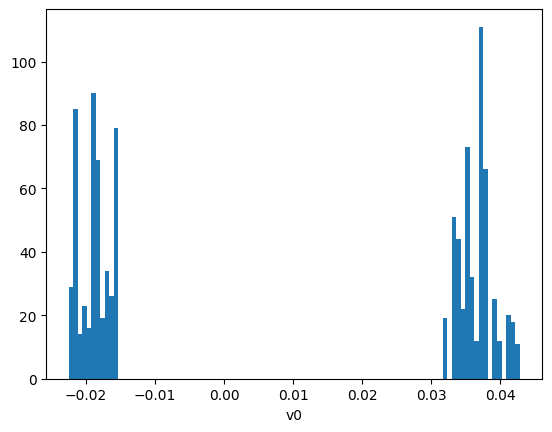

In [10]:

for batch in trainloader:
    x0 = batch[:, 0].to(device).float()
    x1 = batch[:, 1].to(device).float()

    v0 = feature_network(x0).squeeze()
    xor_bits = reduce(x0[: , :5], 'b n -> b', 'sum') % 2
    extra_bits = x0[:, -1]
    
    break


from tabulate import tabulate

# Assuming v0, xor_bits, and extra_bits are already defined as PyTorch tensors

# Convert the tensors to Python lists
v0_list = v0.tolist()
xor_bits_list = xor_bits.tolist()
extra_bits_list = extra_bits.tolist()
# Create a list of lists containing the values at each index
table_data = [[i, round(v0_list[i],3), xor_bits_list[i], extra_bits_list[i]] for i in range(len(v0_list))]
# Define the table headers
headers = ["Index", "v0", "xor_bits", "extra_bits"]
# Print the table using tabulate
print(tabulate(table_data, headers, tablefmt="grid"))


# plot v0_list histogram
import matplotlib.pyplot as plt
plt.hist(v0_list, bins=100)
plt.xlabel('v0')

